In [1]:
!git clone https://github.com/FrancescoFarinola/SQuAD/

Cloning into 'SQuAD'...
remote: Enumerating objects: 197, done.
remote: Counting objects: 100% (197/197), done.
remote: Compressing objects: 100% (130/130), done.
remote: Total 197 (delta 107), reused 145 (delta 64), pack-reused 0
Receiving objects: 100% (197/197), 218.60 MiB | 31.26 MiB/s, done.
Resolving deltas: 100% (107/107), done.
Checking out files: 100% (23/23), done.


In [2]:
%%capture
%cd SQuAD/
!pip install gensim==4.0.0
!pip install nltk
!pip install chars2vec
!pip install spacy
!pip install symspellpy

In [3]:
import pandas as pd
from keras.utils.vis_utils import plot_model
from tensorflow.python.keras.callbacks import EarlyStopping
from tensorflow.python.keras.utils.np_utils import to_categorical
from tensorflow import one_hot
import load_data
import preprocess
import utils
import our_model
import sys
import io
import json

from os.path import isfile
import numpy as np
#import cupy as np
from tensorflow.keras.preprocessing.text import tokenizer_from_json 
from settings import EMBEDDING_DIM, EPOCHS, BATCH_SIZE, MODELS_DIR
#from settings import MAX_QUESTION_LENGTH, MAX_CONTEXT_LENGTH, MAX_TEXT_LENGTH

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


/usr/local/lib/python3.7/dist-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [4]:
from preprocess import nlp
print("Loading dataset...")
dataframe = load_data.load_dataset()
print(dataframe.shape)
print("Splitting train and test set...")
train_df, test_df = load_data.split_test_set(dataframe)
print(train_df.shape, test_df.shape)
print("Splitting train and validation set...")
train_df, val_df = load_data.split_validation_set(train_df, rate=0.2)
print(train_df.shape, val_df.shape)

Loading dataset...
(87599, 6)
Splitting train and test set...
(78161, 6) (9438, 6)
Splitting train and validation set...
(61143, 6) (17018, 6)


In [230]:
val_cfr = val_df.sort_values(by='id', inplace=False)
val_cfr.drop(columns=['title', 'context', 'answer_start', 'id'], inplace=True)
val_cfr.reset_index(inplace=True, drop=True)

with open("predictions.json", 'r') as f:
  predictions =json.load(f)

val_predictions = dict([(k, predictions.get(k)) for k in val_df.id.values])
val_cfr.insert(1, 'prediction', list(zip(*sorted(val_predictions.items())))[1])
val_cfr

,text,prediction,question
0,in the late 1990s,"September 4, 1981",When did Beyonce start becoming popular?
1,singing and dancing,"Houston, Texas",What areas did Beyonce compete in when she was...
2,2003,1990s,When did Beyonce leave Destiny's Child and bec...
3,acting,"Beautiful Liar"". Beyoncé also ventured into ac...","After her second solo album, what other entert..."
4,Jay Z,Jay Z,Which artist did Beyonce marry?
...,...,...,...
17013,natural gas,gas plants,What type of power plant is Darbytown?
17014,61,61,How many kilometers of sewer lines exist in Ri...
17015,44-million-gallon,44-million-gallon,How much water is contained in Shockoe Retenti...
17016,"62,000",70 million,How many Richmond inhabitants get their water ...


In [311]:
exact = val_cfr.loc[val_cfr.text == val_cfr.prediction]
exact.reset_index(inplace=True, drop=True)
print(f"Correct predictions are: {len(exact)} ({100*len(exact)/len(val_cfr):.2f}%)")

Correct predictions are: 7011 (41.20%)


In [312]:
incorrect = val_cfr.loc[val_cfr.text != val_cfr.prediction]
incorrect.reset_index(inplace=True, drop=True)
print(f"Incorrect predictions are: {len(incorrect)} ({100*len(incorrect)/len(val_cfr):.2f}%)")
incorrect

Incorrect predictions are: 10007 (58.80%)


,text,prediction,question
0,in the late 1990s,"September 4, 1981",When did Beyonce start becoming popular?
1,singing and dancing,"Houston, Texas",What areas did Beyonce compete in when she was...
2,2003,1990s,When did Beyonce leave Destiny's Child and bec...
3,acting,"Beautiful Liar"". Beyoncé also ventured into ac...","After her second solo album, what other entert..."
4,"love, relationships, and monogamy","love, relationships, and monogamy, as well as ...","In her music, what are some recurring elements..."
...,...,...,...
10002,Staples Mill Road Station,Amtrak,What station services all southern rail traffi...
10003,Main Street Station,Amtrak,What is the name of the railroad station insid...
10004,North Anna Nuclear Generating Station,North Anna,"Along with Surry Nuclear Generating Station, w..."
10005,natural gas,gas plants,What type of power plant is Darbytown?


In [313]:
import re
def has_numbers(inputString):
  return bool(re.search(r'\d', inputString))

def find_correct_quantities(incorrect):
  correct_quantities = []
  for idx, row in incorrect.iterrows():
    for word in row.prediction.split():
      if has_numbers(word) and word in row.text.split():
          correct_quantities.append(row)
  return pd.DataFrame(correct_quantities)

correct_quantities = find_correct_quantities(incorrect)
correct_quantities.drop_duplicates(keep=False, inplace=True)
print(f"Of the {len(val_cfr)} wrong predictions, {len(correct_quantities)} ({100*len(correct_quantities)/len(val_cfr):.2f}%) contain the correct quantity")
print("Sometimes the answer predicted is also more precise than the one given in the dataset, so the model captures quite well the context and gives enough importance to each token in the question")
correct_quantities.head(30)

Of the 17018 wrong predictions, 635 (3.73%) contain the correct quantity
Sometimes the answer predicted is also more precise than the one given in the dataset, so the model captures quite well the context and gives enough importance to each token in the question


,text,prediction,question
25,2007,April 2007,Beyonce's first world tour was when?
36,the 2011 Glastonbury Festival,2011 Glastonbury Festival,Beyonce became the first female artist to perf...
94,118 million,over 118 million,"Totaling worldwide, how many records as Beyonc..."
111,late 1990s,1990s,In which decade did Beyonce become famous?
131,November 2003,2003,In what year did Beyonce embark on her Dangero...
145,"310,000 copies","310,000",How many copies did the album sell in its firs...
172,September 2015,2015,When will they meet?
204,2013,January 2013,When did she appear on the cover of GQ?
218,around 8 million copies,8 million,How many copies did Crazy in Love sell?
219,15 million,over 15 million,How many albums has Beyonce as a solo artist s...


In [314]:
incorrect = incorrect.iloc[incorrect.index.difference(correct_quantities.index)].reset_index(drop=True)
incorrect.shape

(9372, 3)

In [315]:
%%capture
!pip install spacy
import spacy
spacy.cli.download("en_core_web_sm")
nlp = spacy.load("en_core_web_sm", disable=['parser', 'senter', 'attribute_ruler'])
STOPWORDS = nlp.Defaults.stop_words

In [316]:
def find_partially_correct(incorrect):
  partially_correct = []
  for idx, row in incorrect.iterrows():
    count = 0
    for word in row.text.split():
      if word in row.prediction:
        count = count + 1
    if count >= 2:
      partially_correct.append(row)
  return pd.DataFrame(partially_correct)

partially_correct = find_partially_correct(incorrect)
print(f"Of the {len(val_cfr)} wrong predictions, {len(partially_correct)} ({100*len(partially_correct)/len(val_cfr):.2f}%) contain the correct answer with high probability")
partially_correct

Of the 17018 wrong predictions, 2990 (17.57%) contain the correct answer with high probability


,text,prediction,question
4,"love, relationships, and monogamy","love, relationships, and monogamy, as well as ...","In her music, what are some recurring elements..."
17,The Fighting Temptations,The Fighting Temptations as Lilly,Beyonce starred with Cuba Gooding Jr. in which...
23,The Pink Panther,Pink Panther,What movie did Beyonce act in 2006?
25,24 million,$24 million,How much money did Beyonce's tour make in 2007?
26,119.5 million,$119.5 million,"In 2009, Beyonce started her second world tour..."
...,...,...,...
9333,Carrère and Hastings,Beaux-Arts architects Carrère and Hastings,Who designed the Commonwealth Club?
9342,Forest Hill Amusement Park,"Azalea Garden, Forest Hill Park",What was previously located at the present loc...
9351,Public Broadcasting,Public Broadcasting Service,What type of channel is WCVW 57?
9358,South University - Richmond,South University,What is a for-profit university in Richmond?


In [317]:
incorrect = incorrect.iloc[incorrect.index.difference(partially_correct.index)].reset_index(drop=True)
incorrect.shape

(6382, 3)

Among those answers we can distinguish different types of predicted answers:
  

1.   There are some answers in which quantities are predicted correctly but the model generates along with the quantity and without spacing, the correct unit measure (i.e. True: 158.8 million, Predicted: $158.8 million)
2.   In some cases, the answer predicted gives even more precise information than the one provided in the dataset, so the model captures quite well the context and gives enough importance to each token in the question



In [318]:
def partial_match(incorrect):
  one_correct = []
  for idx, row in incorrect.iterrows():
    count = 0
    for word in row.prediction.split():
      if word in row.text.split() and word not in STOPWORDS:
        count = count + 1
    if count >= 1:
      one_correct.append(row)
  return pd.DataFrame(one_correct)

intersection = partial_match(incorrect)
print(f"Of the {len(val_cfr)} wrong predictions, {len(intersection)} ({100*len(intersection)/len(val_cfr):.2f}%) contain one word with exact match without considering stopwords")
intersection.head(10)

Of the 17018 wrong predictions, 1295 (7.61%) contain one word with exact match without considering stopwords


,text,prediction,question
29,minute,the world per minute,Beyonce was listed in 2011 as the highest paid...
30,writing,writing award,Beyonce won an award for which activity in 2011?
33,Life Is But a Dream,Life,Beyonce's documentary movie was called what?
40,Vogue,Vogue magazine,Which magazine did Beyonce pose on the cover f...
42,Tidal,streaming service Tidal,"Beyonce released the song ""Formation"" on which..."
67,African-American,African-American community,Which racial community gave criticism to Beyonce?
73,fashion retailer Topshop,Parkwood Topshop Athletic Ltd,Who did Bayonce's management go into business ...
79,Ike,Hurricane Ike three,What hurricane years later after Katrina did t...
83,Dangerously in Love,Love,What album made her a worldwide known artist?
93,Fighting Temptations,Fighting Temptation,What song was the lead single from the film's ...


In [319]:
nlp_texts = nlp.pipe(incorrect.text.values, disable=["tok2vec", "tagger", "lemmatizer"])
ner_texts = [[(ent.text, ent.label_) for ent in doc.ents] for doc in nlp_texts]
ner_texts[:5]

[[('the late 1990s', 'DATE')], [], [('2003', 'DATE')], [], []]

In [320]:
nlp_preds = nlp.pipe(incorrect.prediction.values, disable=["tok2vec", "tagger", "lemmatizer"])
ner_preds = [[(ent.text, ent.label_) for ent in doc.ents] for doc in nlp_preds]
ner_preds[:5]

[[('September 4, 1981', 'DATE')],
 [('Houston', 'GPE'), ('Texas', 'GPE')],
 [],
 [('Beyoncé', 'ORG')],
 []]

In [321]:
def get_ners(x):
  if len(x):
    return [t[1] for t in x]
  return []

text_ner = list(map(get_ners, ner_texts))
pred_ner = list(map(get_ners, ner_preds))
list(zip(text_ner[:10], pred_net[:10]))

[(['DATE'], ['DATE']),
 ([], ['GPE', 'GPE']),
 (['DATE'], []),
 ([], ['ORG']),
 ([], []),
 (['PERSON'], []),
 ([], ['GPE', 'GPE']),
 (['NORP'], ['ORG']),
 ([], ['NORP']),
 (['GPE'], ['GPE'])]

In [322]:
bool_ner = [text_ner[i]== pred_ner[i] for i in range(len(text_ner)) if text_ner[i]]
print(f'{sum(bool_ner)} ners (out of {len(bool_ner)}) are equal.')
print(f'So, even if the prediction is incorrect, ner is guessed in {100*sum(bool_ner)/len(bool_ner):.2f}% of cases when available')

890 ners (out of 2703) are equal.
So, even if the prediction is incorrect, ner is guessed in 32.93% of cases when available


In [323]:
f'Answers for which NE category is available: {100*len(bool_ner)/len(val_cfr):.2f}%'

'Answers for which NE category is available: 15.88%'

In [324]:
f'Answers for which NE category is predicted correctly: {100*sum(bool_ner)/len(val_cfr):.2f}%'

'Answers for which NE category is predicted correctly: 5.23%'

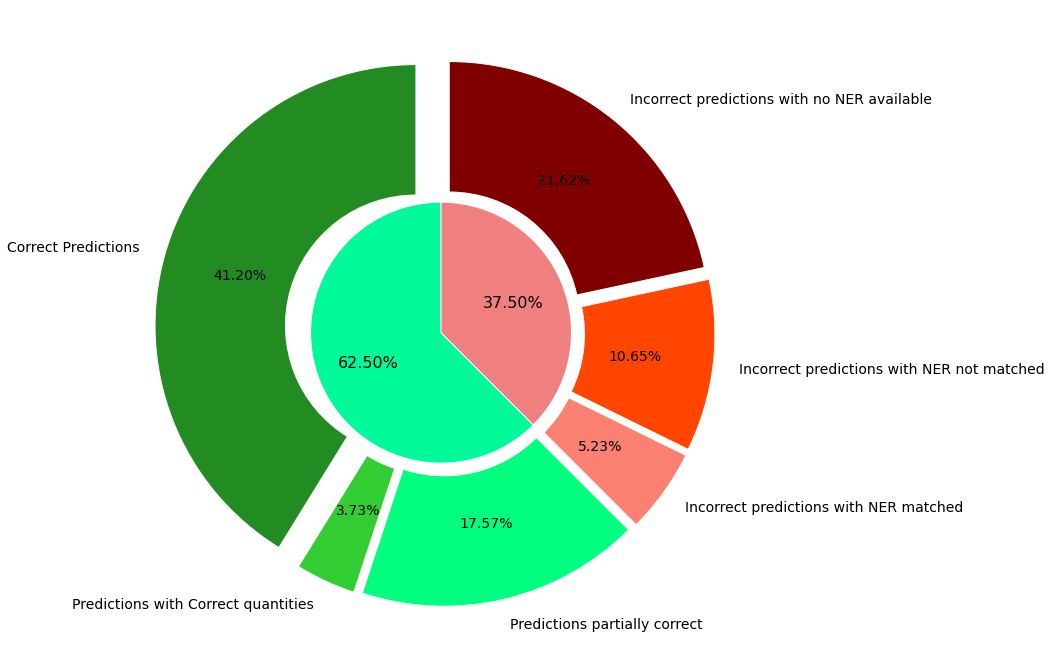

In [369]:
fig, ax = plt.subplots(figsize=(24,12))
size = 0.5
explode = (0.10, 0.05, 0.05, 0.05, 0.05, 0.05)

outer_labels = ['Correct Predictions',
          'Predictions with Correct quantities',
          'Predictions partially correct',
          'Incorrect predictions with NER matched',
          'Incorrect predictions with NER not matched',
          'Incorrect predictions with no NER available']

inner_labels = ['Potentially Correct predictions',
                'Incorrect predictions']

inner_data = [len(exact) + len(correct_quantities)+len(partially_correct),
              len(incorrect)]

ax.pie(data, radius=1,
       labels=outer_labels,
       explode=explode,
       autopct='%1.2f%%',
       pctdistance=0.7,
       wedgeprops=dict(width=size, edgecolor='w'),
       colors=['forestgreen', 'limegreen', 'springgreen', 'salmon', 'orangered', 'maroon'],
       startangle=90,
       textprops={'fontsize': 14})

ax.pie(inner_data, radius=1-size, 
       
       wedgeprops=dict(width=size, edgecolor='w'),
       labeldistance=0.1,
       autopct='%1.2f%%',
       colors=['mediumspringgreen','lightcoral'], 
       startangle=90,
       textprops={'fontsize': 16})

ax.set(aspect="equal")
plt.show()